In [1]:
! wget https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5  -O electron.hdf5

--2025-04-07 21:38:39--  https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.53.35, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128927319 (123M) [application/octet-stream]
Saving to: ‘electron.hdf5’

electron.hdf5       100%[===================>] 122.95M  13.4MB/s    in 11s     

2025-04-07 21:38:52 (11.2 MB/s) - ‘electron.hdf5’ saved [128927319/128927319]



In [2]:
! wget https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5  -O photon.hdf5

--2025-04-07 21:38:52--  https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.28, 128.142.170.17, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119703858 (114M) [application/octet-stream]
Saving to: ‘photon.hdf5’

photon.hdf5         100%[===================>] 114.16M   154KB/s    in 8m 23s  

2025-04-07 21:47:17 (232 KB/s) - ‘photon.hdf5’ saved [119703858/119703858]



In [3]:
import h5py
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split 
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Open the HDF5 file
with h5py.File('/kaggle/working/photon.hdf5', 'r') as f:
    # List all groups/datasets in the file
    print("Keys:", list(f.keys()))

    features = f['X']
    print("Features shape:", features.shape)

    target = f['y']
    print("Target shape:", target.shape)
    
    # Convert the target dataset to a numpy array and get unique values
    target_array = np.array(target)
    unique_elements = np.unique(target_array)
    
    print("Unique elements in target:", unique_elements)
    print("Number of unique elements:", len(unique_elements))

Keys: ['X', 'y']
Features shape: (249000, 32, 32, 2)
Target shape: (249000,)
Unique elements in target: [0.]
Number of unique elements: 1


In [5]:
# Open the HDF5 file
with h5py.File('/kaggle/working/electron.hdf5', 'r') as f:
    # List all groups/datasets in the file
    print("Keys:", list(f.keys()))

    features = f['X']
    print("Features shape:", features.shape)

    target = f['y']
    print("Target shape:", target.shape)
    
    # Convert the target dataset to a numpy array and get unique values
    target_array = np.array(target)
    unique_elements = np.unique(target_array)
    
    print("Unique elements in target:", unique_elements)
    print("Number of unique elements:", len(unique_elements))

Keys: ['X', 'y']
Features shape: (249000, 32, 32, 2)
Target shape: (249000,)
Unique elements in target: [1.]
Number of unique elements: 1


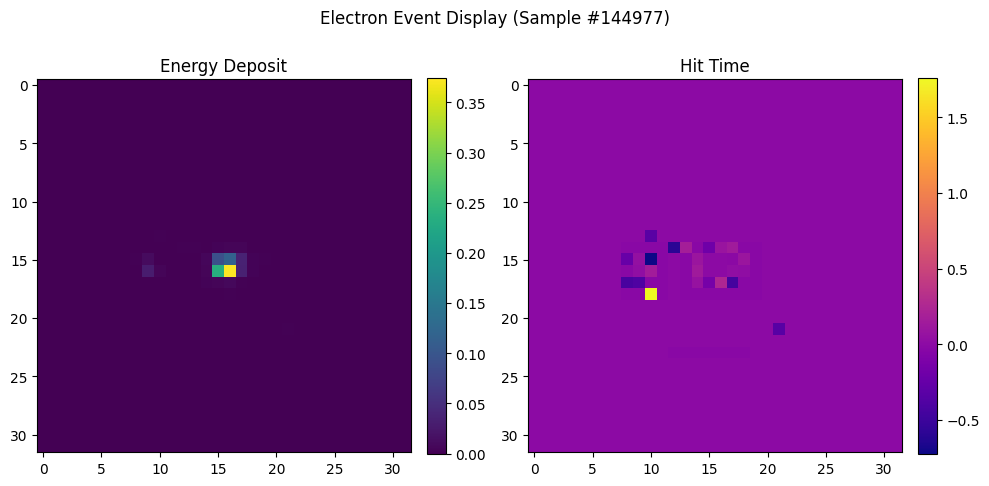

In [6]:
# Open the HDF5 file
with h5py.File('/kaggle/working/electron.hdf5', 'r') as f:
    # Assuming the dataset is called 'images' - adjust if needed
    electron = f['X'][:]  # Load all data into memory
    
# Select a random sample
sample_idx = np.random.randint(0, len(electron))
sample = electron[sample_idx]

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot energy channel (channel 0)
im1 = ax1.imshow(sample[..., 0], cmap='viridis', vmin=0)
ax1.set_title('Energy Deposit')
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# Plot time channel (channel 1)
im2 = ax2.imshow(sample[..., 1], cmap='plasma')
ax2.set_title('Hit Time')
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.suptitle(f'Electron Event Display (Sample #{sample_idx})')
plt.tight_layout()
plt.show()

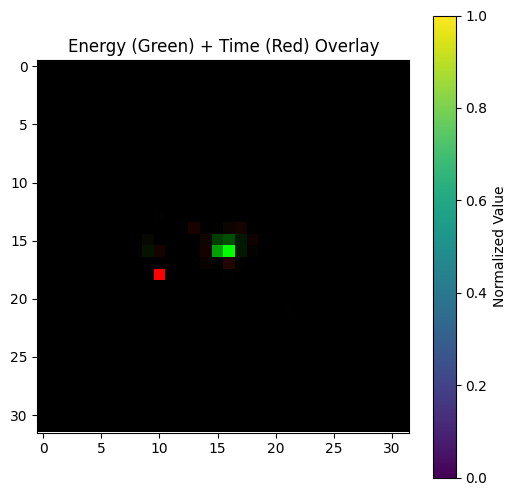

In [7]:
# Create an RGB image combining both channels
rgb_image = np.zeros((32, 32, 3))

# Normalize channels
energy_norm = sample[..., 0] / np.max(sample[..., 0])
time_norm = sample[..., 1] / np.max(sample[..., 1])

# Energy in green channel, time in red channel
rgb_image[..., 1] = energy_norm  # Green = energy
rgb_image[..., 0] = time_norm    # Red = time

plt.figure(figsize=(6, 6))
plt.imshow(rgb_image)
plt.title('Energy (Green) + Time (Red) Overlay')
plt.colorbar(label='Normalized Value')
plt.show()

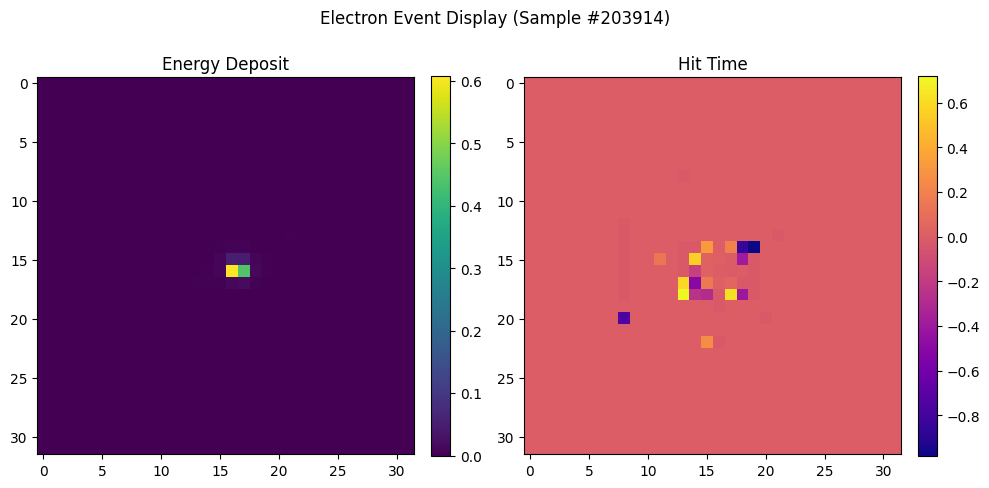

In [8]:
# Open the HDF5 file
with h5py.File('/kaggle/working/photon.hdf5', 'r') as f:
    # Assuming the dataset is called 'images' - adjust if needed
    photon = f['X'][:]  # Load all data into memory
    
# Select a random sample
sample_idx = np.random.randint(0, len(photon))
sample = photon[sample_idx]

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot energy channel (channel 0)
im1 = ax1.imshow(sample[..., 0], cmap='viridis', vmin=0)
ax1.set_title('Energy Deposit')
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# Plot time channel (channel 1)
im2 = ax2.imshow(sample[..., 1], cmap='plasma')
ax2.set_title('Hit Time')
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.suptitle(f'Electron Event Display (Sample #{sample_idx})')
plt.tight_layout()
plt.show()

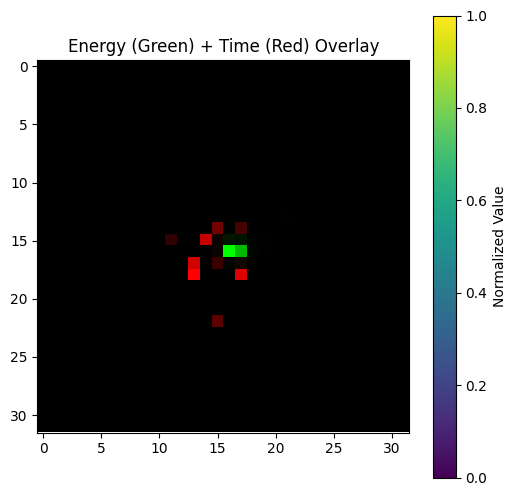

In [9]:
# Create an RGB image combining both channels
rgb_image = np.zeros((32, 32, 3))

# Normalize channels
energy_norm = sample[..., 0] / np.max(sample[..., 0])
time_norm = sample[..., 1] / np.max(sample[..., 1])

# Energy in green channel, time in red channel
rgb_image[..., 1] = energy_norm  # Green = energy
rgb_image[..., 0] = time_norm    # Red = time

plt.figure(figsize=(6, 6))
plt.imshow(rgb_image)
plt.title('Energy (Green) + Time (Red) Overlay')
plt.colorbar(label='Normalized Value')
plt.show()

# Preprocessing

In [10]:
def load_and_split(file_path, label, test_size=0.2, random_state=42):
    """Load data and split into train/test by label."""
    with h5py.File(file_path, 'r') as f:
        X = f['X'][:]  # Shape: (N, 32, 32, 2)
        y = np.full(len(X), label)  # Assign label (0 for electron, 1 for photon)
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test

# Load and split electron (label=0) and photon (label=1)
X_e_train, X_e_test, y_e_train, y_e_test = load_and_split('/kaggle/working/electron.hdf5', label=0)
X_p_train, X_p_test, y_p_train, y_p_test = load_and_split('/kaggle/working/photon.hdf5', label=1)

# Concatenate splits (your requested approach)
X_train = np.concatenate([X_e_train, X_p_train])
X_test = np.concatenate([X_e_test, X_p_test])
y_train = np.concatenate([y_e_train, y_p_train])
y_test = np.concatenate([y_e_test, y_p_test])

# Convert to PyTorch tensors and permute dimensions (NCHW)
X_train = torch.FloatTensor(X_train).permute(0, 3, 1, 2)  # (N, 2, 32, 32)
X_test = torch.FloatTensor(X_test).permute(0, 3, 1, 2)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Model Architecture

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet15(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # ResNet blocks: [64, 128, 256, 512] channels
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Model Training

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Acc = 0.6670, Train AUC = 0.7200, Val Acc = 0.6939, Val AUC = 0.7636, LR = 0.001000


Epoch 2: Train Acc = 0.7105, Train AUC = 0.7720, Val Acc = 0.7086, Val AUC = 0.7782, LR = 0.001000


Epoch 3: Train Acc = 0.7164, Train AUC = 0.7800, Val Acc = 0.7148, Val AUC = 0.7809, LR = 0.001000


Epoch 4: Train Acc = 0.7193, Train AUC = 0.7839, Val Acc = 0.7110, Val AUC = 0.7839, LR = 0.001000


Epoch 5: Train Acc = 0.7216, Train AUC = 0.7867, Val Acc = 0.7220, Val AUC = 0.7899, LR = 0.001000


Epoch 6: Train Acc = 0.7232, Train AUC = 0.7890, Val Acc = 0.7062, Val AUC = 0.7837, LR = 0.001000


Epoch 7: Train Acc = 0.7246, Train AUC = 0.7904, Val Acc = 0.7115, Val AUC = 0.7863, LR = 0.001000


Epoch 8: Train Acc = 0.7251, Train AUC = 0.7917, Val Acc = 0.7248, Val AUC = 0.7931, LR = 0.001000


Epoch 9: Train Acc = 0.7257, Train AUC = 0.7927, Val Acc = 0.7261, Val AUC = 0.7958, LR = 0.001000


Epoch 10: Train Acc = 0.7276, Train AUC = 0.7937, Val Acc = 0.7124, Val AUC = 0.7848, LR = 0.001000


Epoch 11: Train Acc = 0.7273, Train AUC = 0.7946, Val Acc = 0.7279, Val AUC = 0.7970, LR = 0.001000


Epoch 12: Train Acc = 0.7276, Train AUC = 0.7951, Val Acc = 0.7287, Val AUC = 0.7972, LR = 0.001000


Epoch 13: Train Acc = 0.7288, Train AUC = 0.7958, Val Acc = 0.7304, Val AUC = 0.8011, LR = 0.001000


Epoch 14: Train Acc = 0.7287, Train AUC = 0.7965, Val Acc = 0.7298, Val AUC = 0.7998, LR = 0.001000


Epoch 15: Train Acc = 0.7291, Train AUC = 0.7970, Val Acc = 0.7304, Val AUC = 0.7983, LR = 0.001000


Epoch 16: Train Acc = 0.7294, Train AUC = 0.7969, Val Acc = 0.7151, Val AUC = 0.7929, LR = 0.001000


Epoch 17: Train Acc = 0.7300, Train AUC = 0.7977, Val Acc = 0.7271, Val AUC = 0.7958, LR = 0.001000


Epoch 18: Train Acc = 0.7340, Train AUC = 0.8027, Val Acc = 0.7331, Val AUC = 0.8047, LR = 0.000500


Epoch 19: Train Acc = 0.7348, Train AUC = 0.8037, Val Acc = 0.7268, Val AUC = 0.7984, LR = 0.000500


Epoch 20: Train Acc = 0.7348, Train AUC = 0.8044, Val Acc = 0.7311, Val AUC = 0.8043, LR = 0.000500


Epoch 21: Train Acc = 0.7349, Train AUC = 0.8047, Val Acc = 0.7332, Val AUC = 0.8038, LR = 0.000500


Epoch 22: Train Acc = 0.7354, Train AUC = 0.8048, Val Acc = 0.7317, Val AUC = 0.8031, LR = 0.000500


Epoch 23: Train Acc = 0.7385, Train AUC = 0.8083, Val Acc = 0.7364, Val AUC = 0.8080, LR = 0.000250


Epoch 24: Train Acc = 0.7386, Train AUC = 0.8087, Val Acc = 0.7361, Val AUC = 0.8080, LR = 0.000250


Epoch 25: Train Acc = 0.7388, Train AUC = 0.8093, Val Acc = 0.7370, Val AUC = 0.8077, LR = 0.000250


Epoch 26: Train Acc = 0.7397, Train AUC = 0.8097, Val Acc = 0.7355, Val AUC = 0.8077, LR = 0.000250


Epoch 27: Train Acc = 0.7394, Train AUC = 0.8100, Val Acc = 0.7360, Val AUC = 0.8078, LR = 0.000250


Epoch 28: Train Acc = 0.7408, Train AUC = 0.8120, Val Acc = 0.7375, Val AUC = 0.8096, LR = 0.000125


Epoch 29: Train Acc = 0.7412, Train AUC = 0.8127, Val Acc = 0.7383, Val AUC = 0.8097, LR = 0.000125


Epoch 30: Train Acc = 0.7418, Train AUC = 0.8130, Val Acc = 0.7377, Val AUC = 0.8097, LR = 0.000125


Epoch 31: Train Acc = 0.7421, Train AUC = 0.8133, Val Acc = 0.7381, Val AUC = 0.8093, LR = 0.000125


Epoch 32: Train Acc = 0.7422, Train AUC = 0.8133, Val Acc = 0.7374, Val AUC = 0.8092, LR = 0.000125


Epoch 33: Train Acc = 0.7432, Train AUC = 0.8148, Val Acc = 0.7390, Val AUC = 0.8100, LR = 0.000063


Epoch 34: Train Acc = 0.7436, Train AUC = 0.8151, Val Acc = 0.7385, Val AUC = 0.8093, LR = 0.000063


Epoch 35: Train Acc = 0.7433, Train AUC = 0.8153, Val Acc = 0.7395, Val AUC = 0.8104, LR = 0.000063


Epoch 36: Train Acc = 0.7431, Train AUC = 0.8153, Val Acc = 0.7388, Val AUC = 0.8103, LR = 0.000063


Epoch 37: Train Acc = 0.7440, Train AUC = 0.8156, Val Acc = 0.7373, Val AUC = 0.8100, LR = 0.000063


Epoch 38: Train Acc = 0.7438, Train AUC = 0.8156, Val Acc = 0.7389, Val AUC = 0.8100, LR = 0.000063


Epoch 39: Train Acc = 0.7437, Train AUC = 0.8159, Val Acc = 0.7396, Val AUC = 0.8103, LR = 0.000063


Epoch 40: Train Acc = 0.7447, Train AUC = 0.8170, Val Acc = 0.7398, Val AUC = 0.8104, LR = 0.000031


Epoch 41: Train Acc = 0.7441, Train AUC = 0.8169, Val Acc = 0.7392, Val AUC = 0.8105, LR = 0.000031


Epoch 42: Train Acc = 0.7447, Train AUC = 0.8170, Val Acc = 0.7389, Val AUC = 0.8104, LR = 0.000031


Epoch 43: Train Acc = 0.7449, Train AUC = 0.8170, Val Acc = 0.7390, Val AUC = 0.8103, LR = 0.000031


Epoch 44: Train Acc = 0.7454, Train AUC = 0.8175, Val Acc = 0.7390, Val AUC = 0.8106, LR = 0.000016


Epoch 45: Train Acc = 0.7455, Train AUC = 0.8179, Val Acc = 0.7386, Val AUC = 0.8104, LR = 0.000016
Early stopping at epoch 45
Best Validation Accuracy: 0.7398, Best AUC: 0.8104


<ipython-input-12-ae1ac1a9ba1f>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Final Test AUC: 0.8104


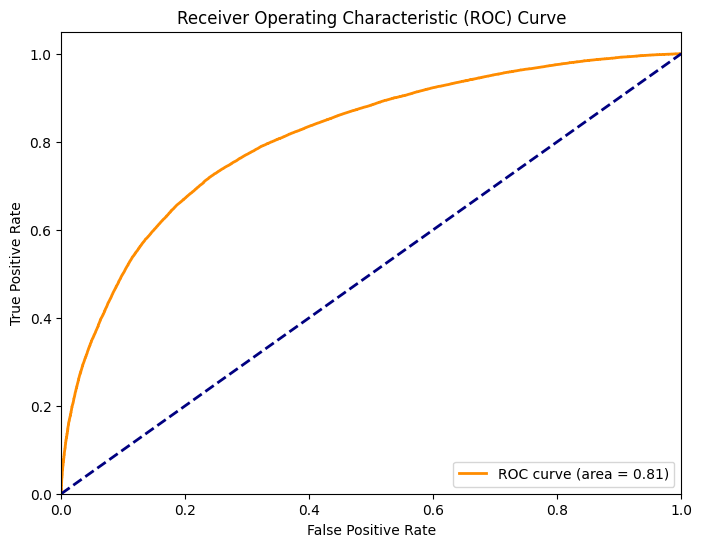

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet15().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

# Early stopping
best_acc = 0.0
patience = 5
epochs_no_improve = 0
early_stop = False

for epoch in range(100):
    model.train()
    train_loss = 0.0
    train_preds, train_true = [], []
    train_probs = []  # Store probabilities for AUC calculation
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/100', leave=False)
    
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        # Get probabilities (softmax) for AUC calculation
        prob = torch.softmax(outputs, dim=1)
        train_probs.extend(prob[:, 1].cpu().detach().numpy())  # Assuming binary classification
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_true.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix(loss=loss.item())
    
    # Calculate training accuracy and AUC
    train_acc = accuracy_score(train_true, train_preds)
    train_auc = roc_auc_score(train_true, train_probs)
    
    # Validation
    model.eval()
    val_preds, val_true = [], []
    val_probs = []  # Store probabilities for AUC calculation
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            prob = torch.softmax(outputs, dim=1)
            val_probs.extend(prob[:, 1].cpu().numpy())  # Assuming binary classification
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_true.extend(labels.cpu().numpy())
    
    val_acc = accuracy_score(val_true, val_preds)
    val_auc = roc_auc_score(val_true, val_probs)
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f'Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Train AUC = {train_auc:.4f}, Val Acc = {val_acc:.4f}, Val AUC = {val_auc:.4f}, LR = {current_lr:.6f}')
    
    # Early stopping and model checkpoint - now considering both accuracy and AUC
    if val_acc > best_acc:
        best_acc = val_acc
        best_auc = val_auc
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            early_stop = True
    
    # You might want to step the scheduler based on AUC instead of accuracy
    scheduler.step(val_auc)  # or val_acc if you prefer
    
    if early_stop:
        break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
print(f'Best Validation Accuracy: {best_acc:.4f}, Best AUC: {best_auc:.4f}')

# Generate confusion matrix and final AUC
model.eval()
all_preds, all_true = [], []
all_probs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        prob = torch.softmax(outputs, dim=1)
        all_probs.extend(prob[:, 1].cpu().numpy())  
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# Calculate final test AUC
test_auc = roc_auc_score(all_true, all_probs)
print(f'Final Test AUC: {test_auc:.4f}')

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_true, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')  # Save the plot
plt.show()

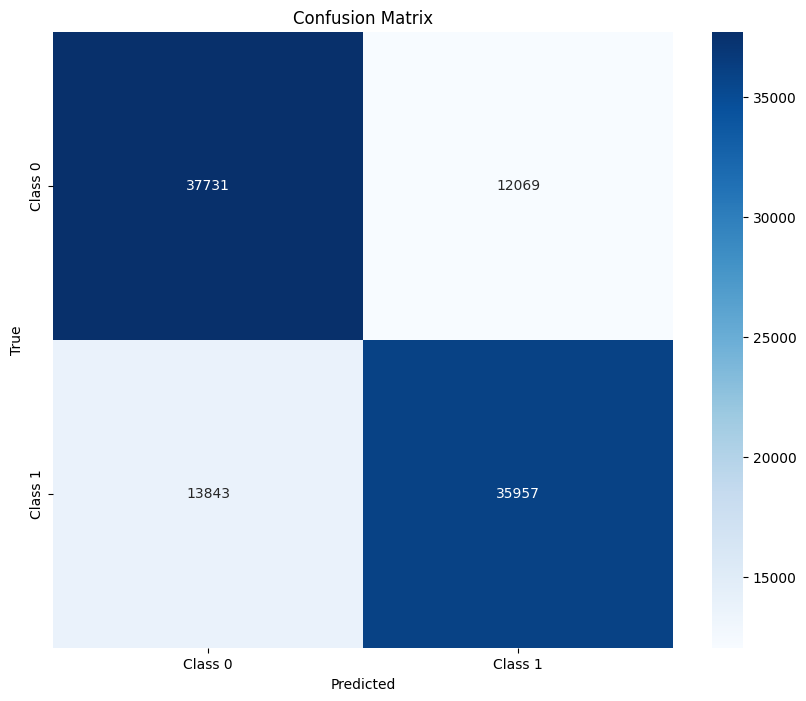

In [13]:
class_names = [f"Class {i}" for i in range(len(np.unique(all_true)))]  # Method 3

# Create confusion matrix
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()